In [ ]:
from PIL import Image, ImageFilter
import numpy as np

# image path
path = "/Users/alayshah/Desktop/DSCF2899.JPG"

image = Image.open(fp=path)

img_data = np.array(image)

brightness_threshold = 100

blur_radius = 500

color_tint = [255, 100, 100]

In [ ]:
# but first a quick helper
# jupyter nb was way too big for github, downscaling image by half, just for visuals
def showSmallerVersionOfImage(img: Image): 
    width, height = img.size
    new_width = int(width * 0.25)
    new_height = int(height * 0.25)
    return img.resize((new_width, new_height), Image.Resampling.LANCZOS)

In [ ]:
# lets look at our input image
showSmallerVersionOfImage(image)

In [3]:
# split the rgb channels -> will be used for luminance form
red_channel = img_data[:, :, 0]
green_channel = img_data[:, :, 1]
blue_channel = img_data[:, :, 2]

# luminance formula (from google says can be used for sRGB) -> .2126 R + .7152 G + .0722 B
# returns 2d array of pixel lumination 
luminance =  (0.2126 * red_channel + 0.7152 * green_channel + 0.0722 * blue_channel)

# we can then convert this to a binary mask on our image white for bright, black for dark
binary_mask = np.where(luminance[:,:] > brightness_threshold, 255, 0).astype(np.uint8)

binary_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(5152, 7728), dtype=uint8)

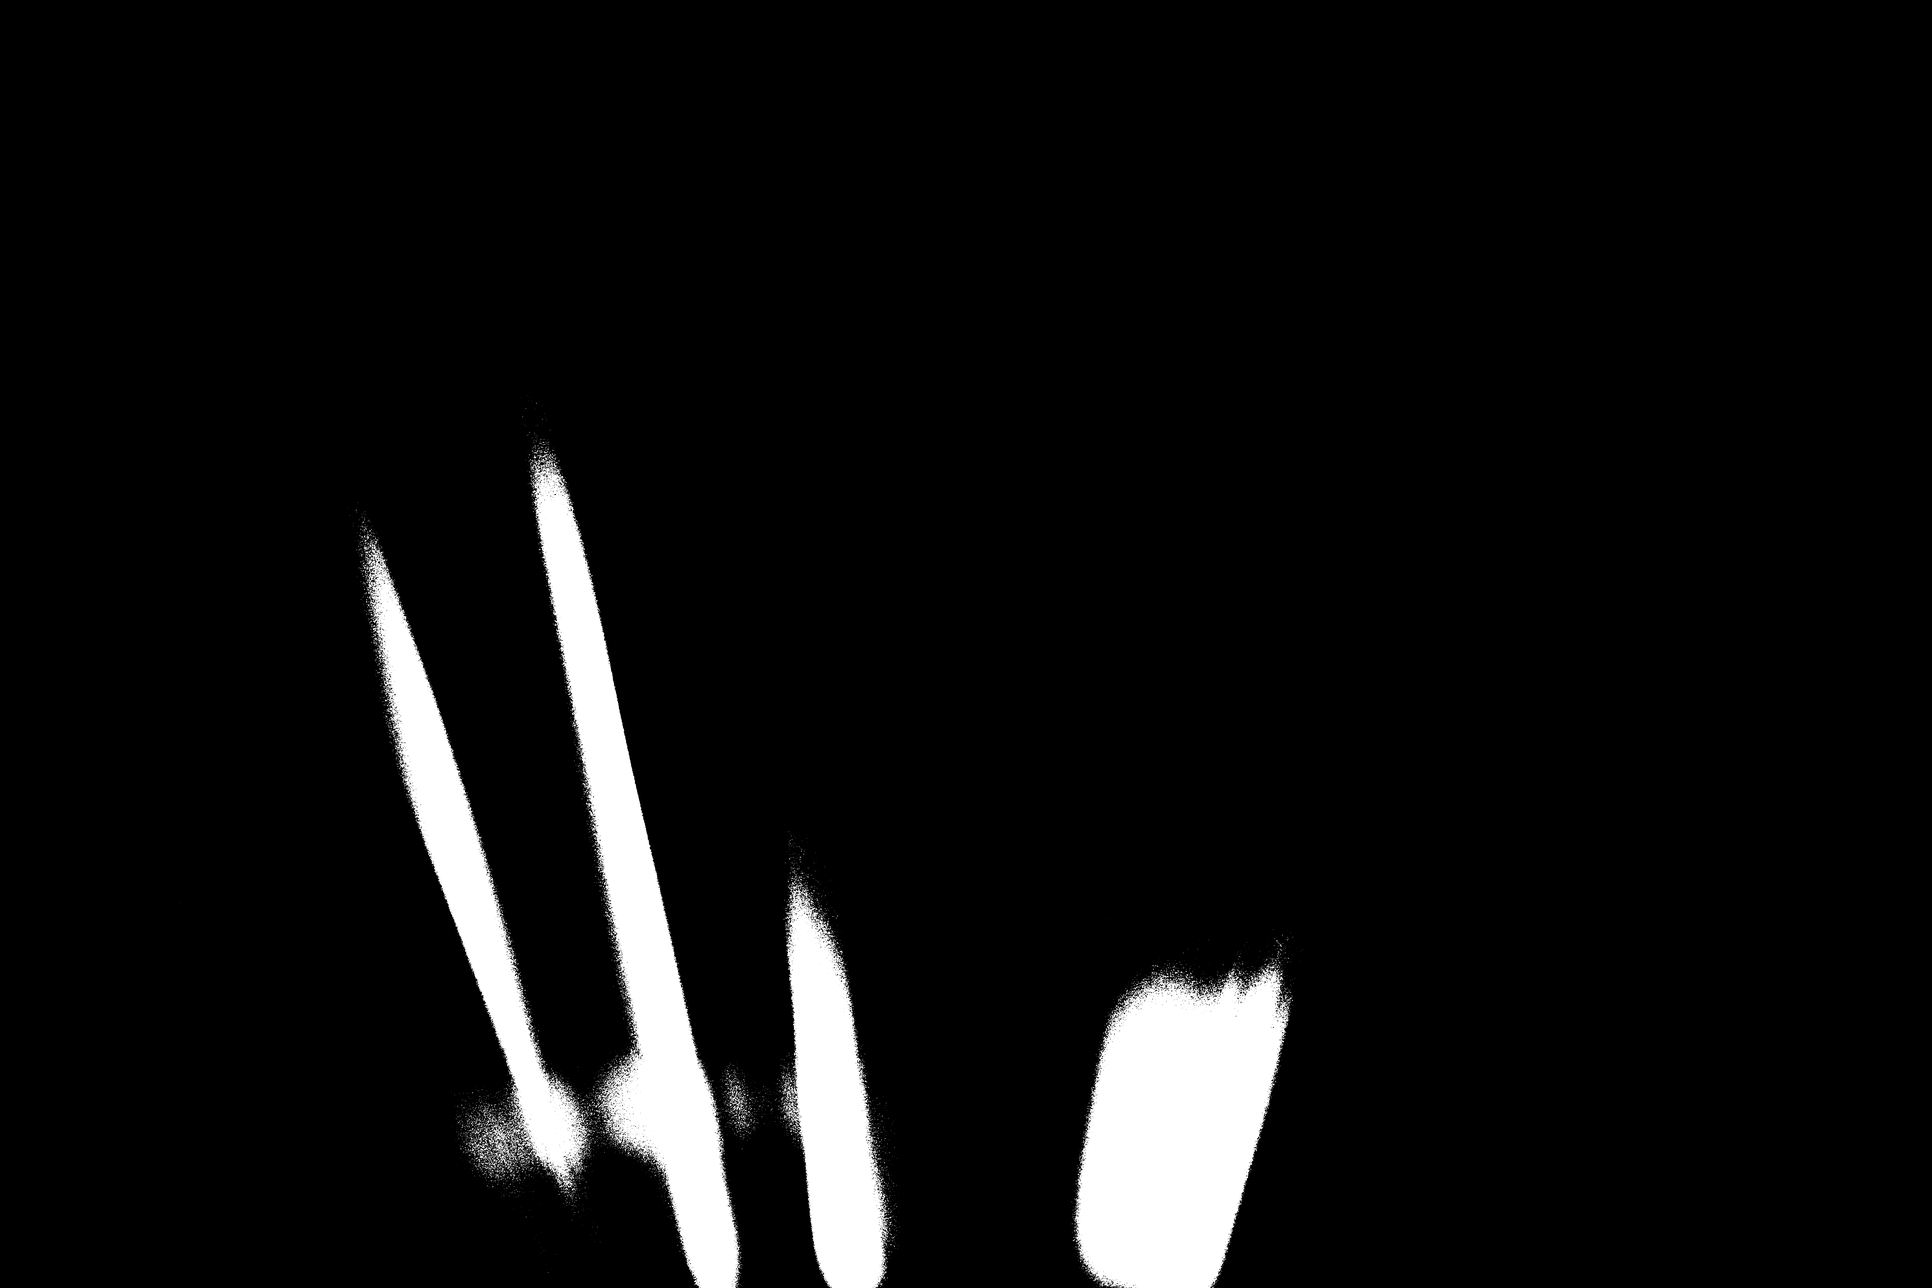

In [4]:
binary_mask_img = Image.fromarray(binary_mask)

# you can now see where the brightest pixels are ! super cool
showSmallerVersionOfImage(binary_mask_img)

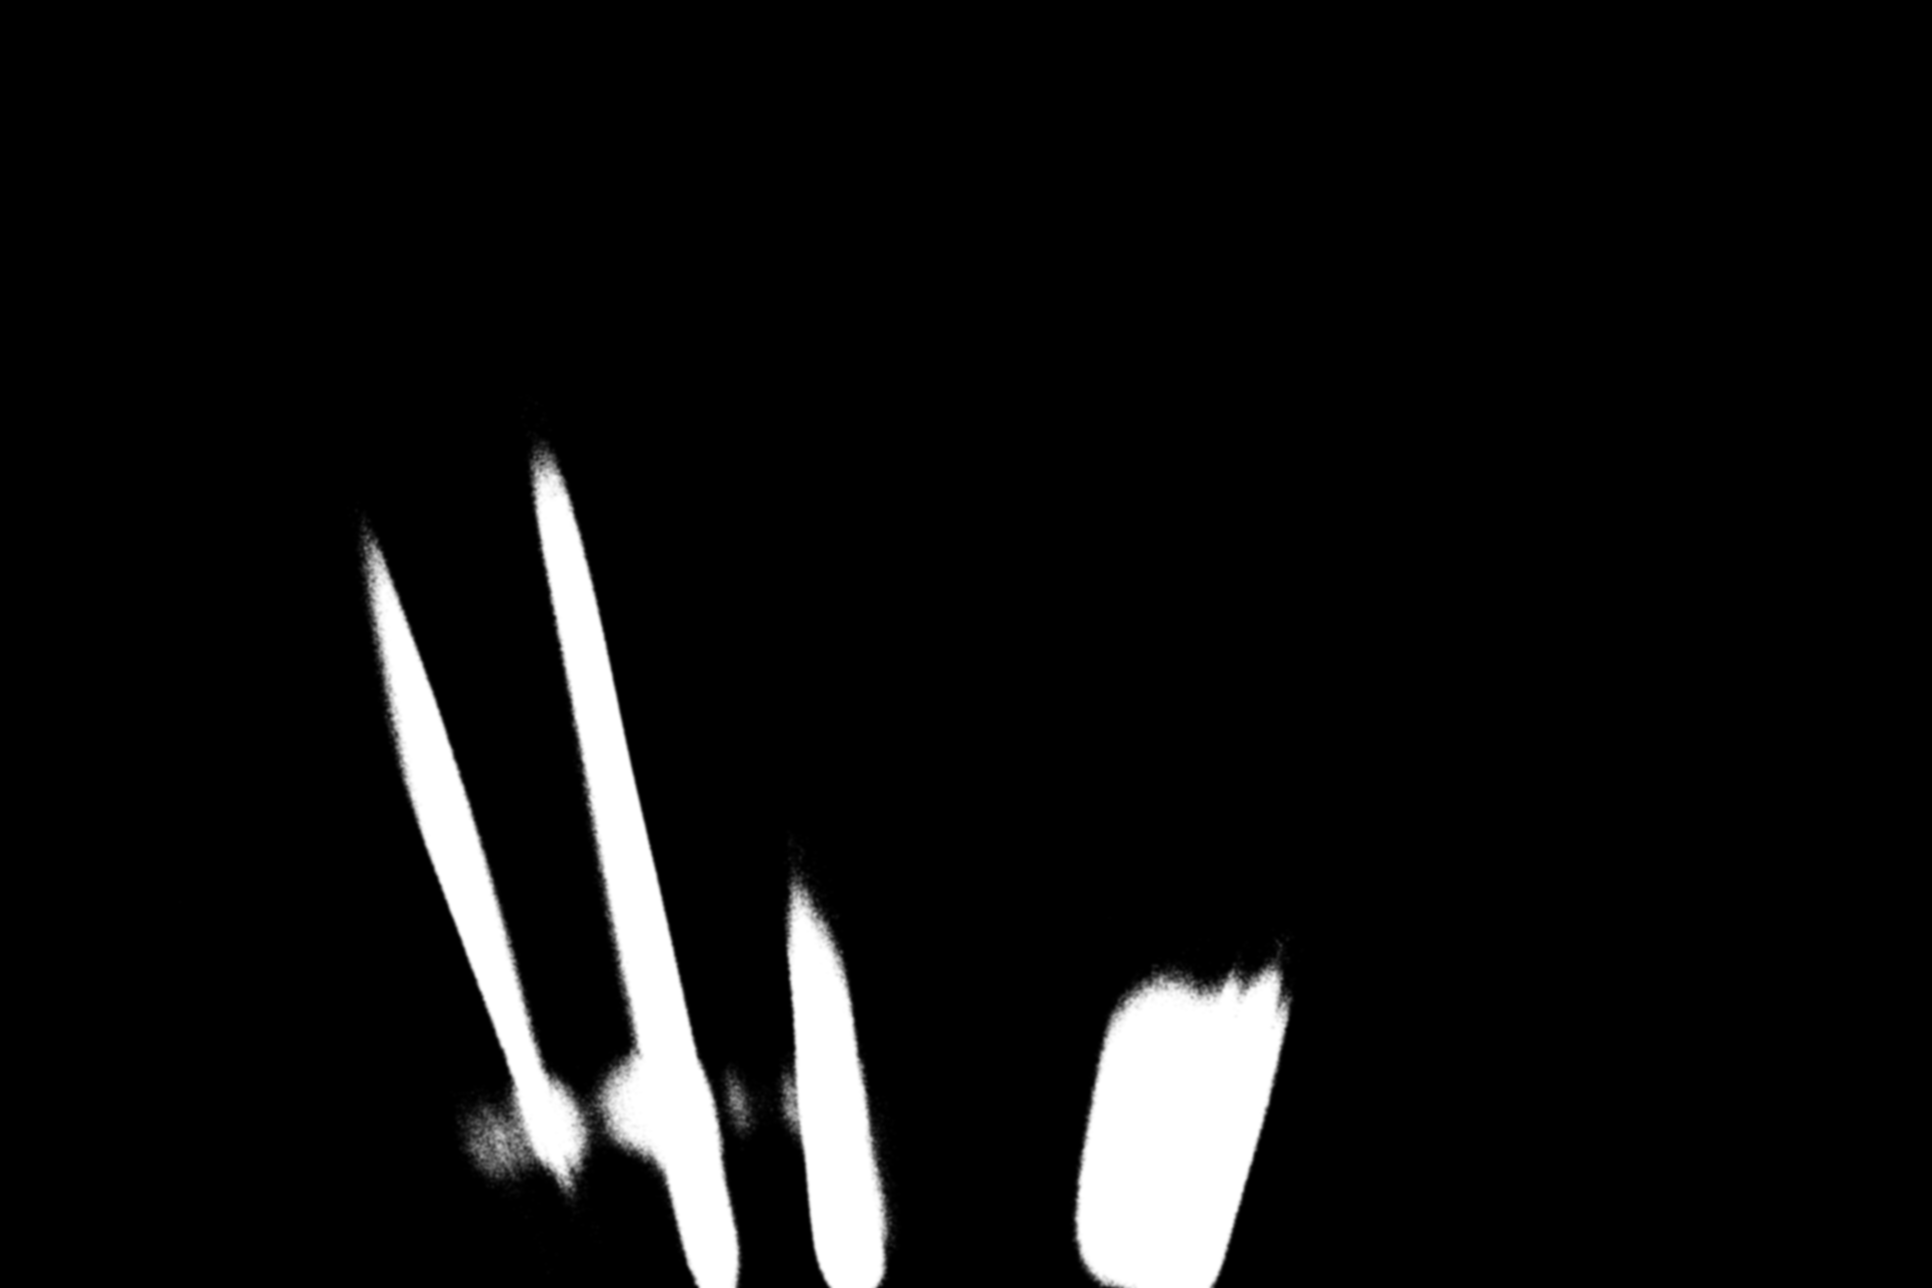

In [14]:
# now that we have the binary mask of the brightest pixels
# we need to create a gaussian blur around the pixels to create the hazy effect we see in halations 

# we can now see where we will be applying the color in our image
blurred_mask = binary_mask_img.filter(ImageFilter.GaussianBlur(radius=5))
showSmallerVersionOfImage(blurred_mask)

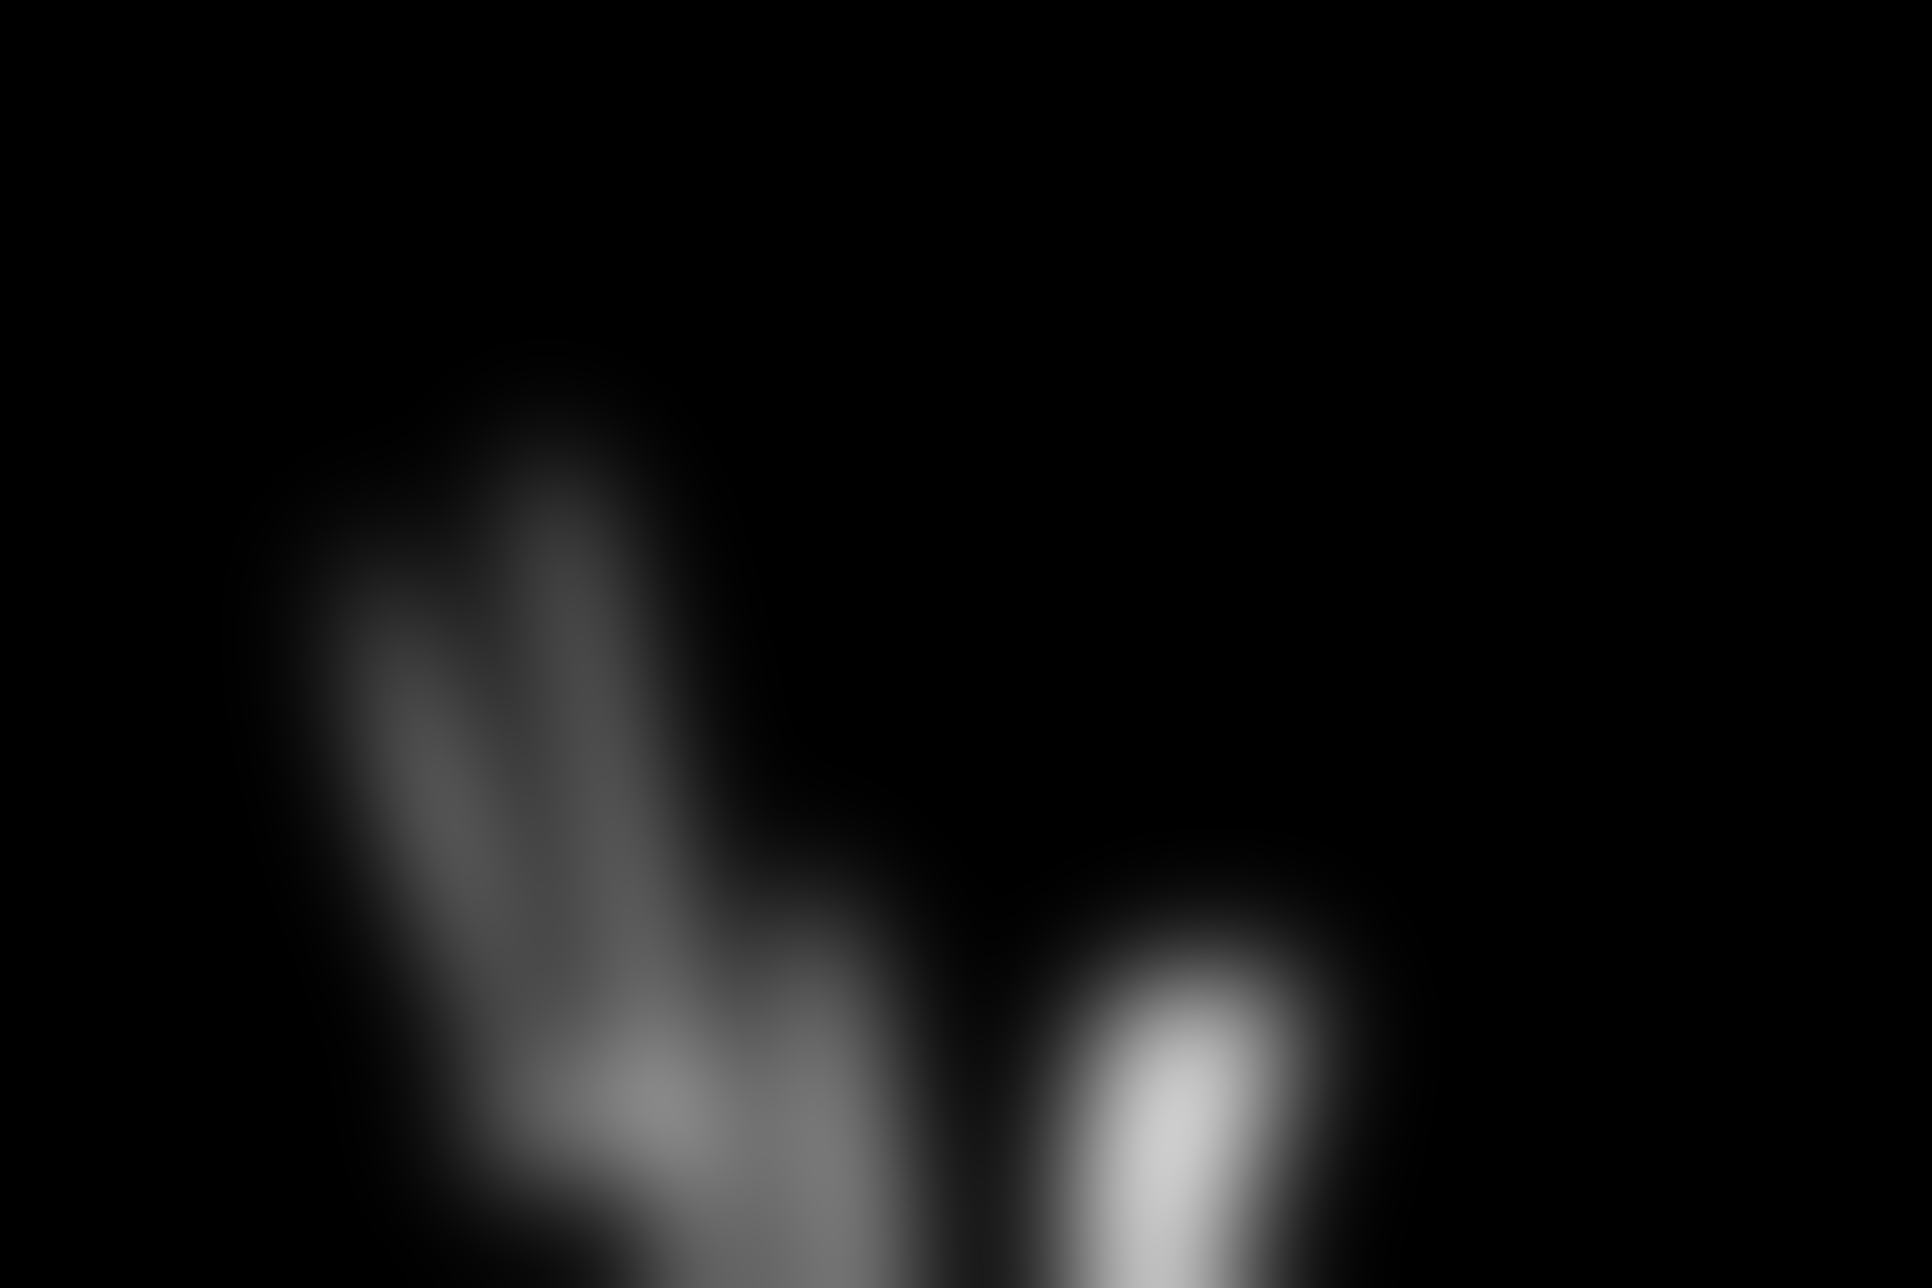

In [ ]:
from scipy.ndimage import gaussian_filter

# I thought this would be quicker 
# but its actually much slower than converting the mask into and image and then applying the blur filter on it... odd
# turns out pillow is highly optimized for images so we'll cont using pillow, even if it means more intermediary image creation 
non_image_blur = gaussian_filter(binary_mask, sigma=150)

showSmallerVersionOfImage(img=Image.fromarray(non_image_blur))

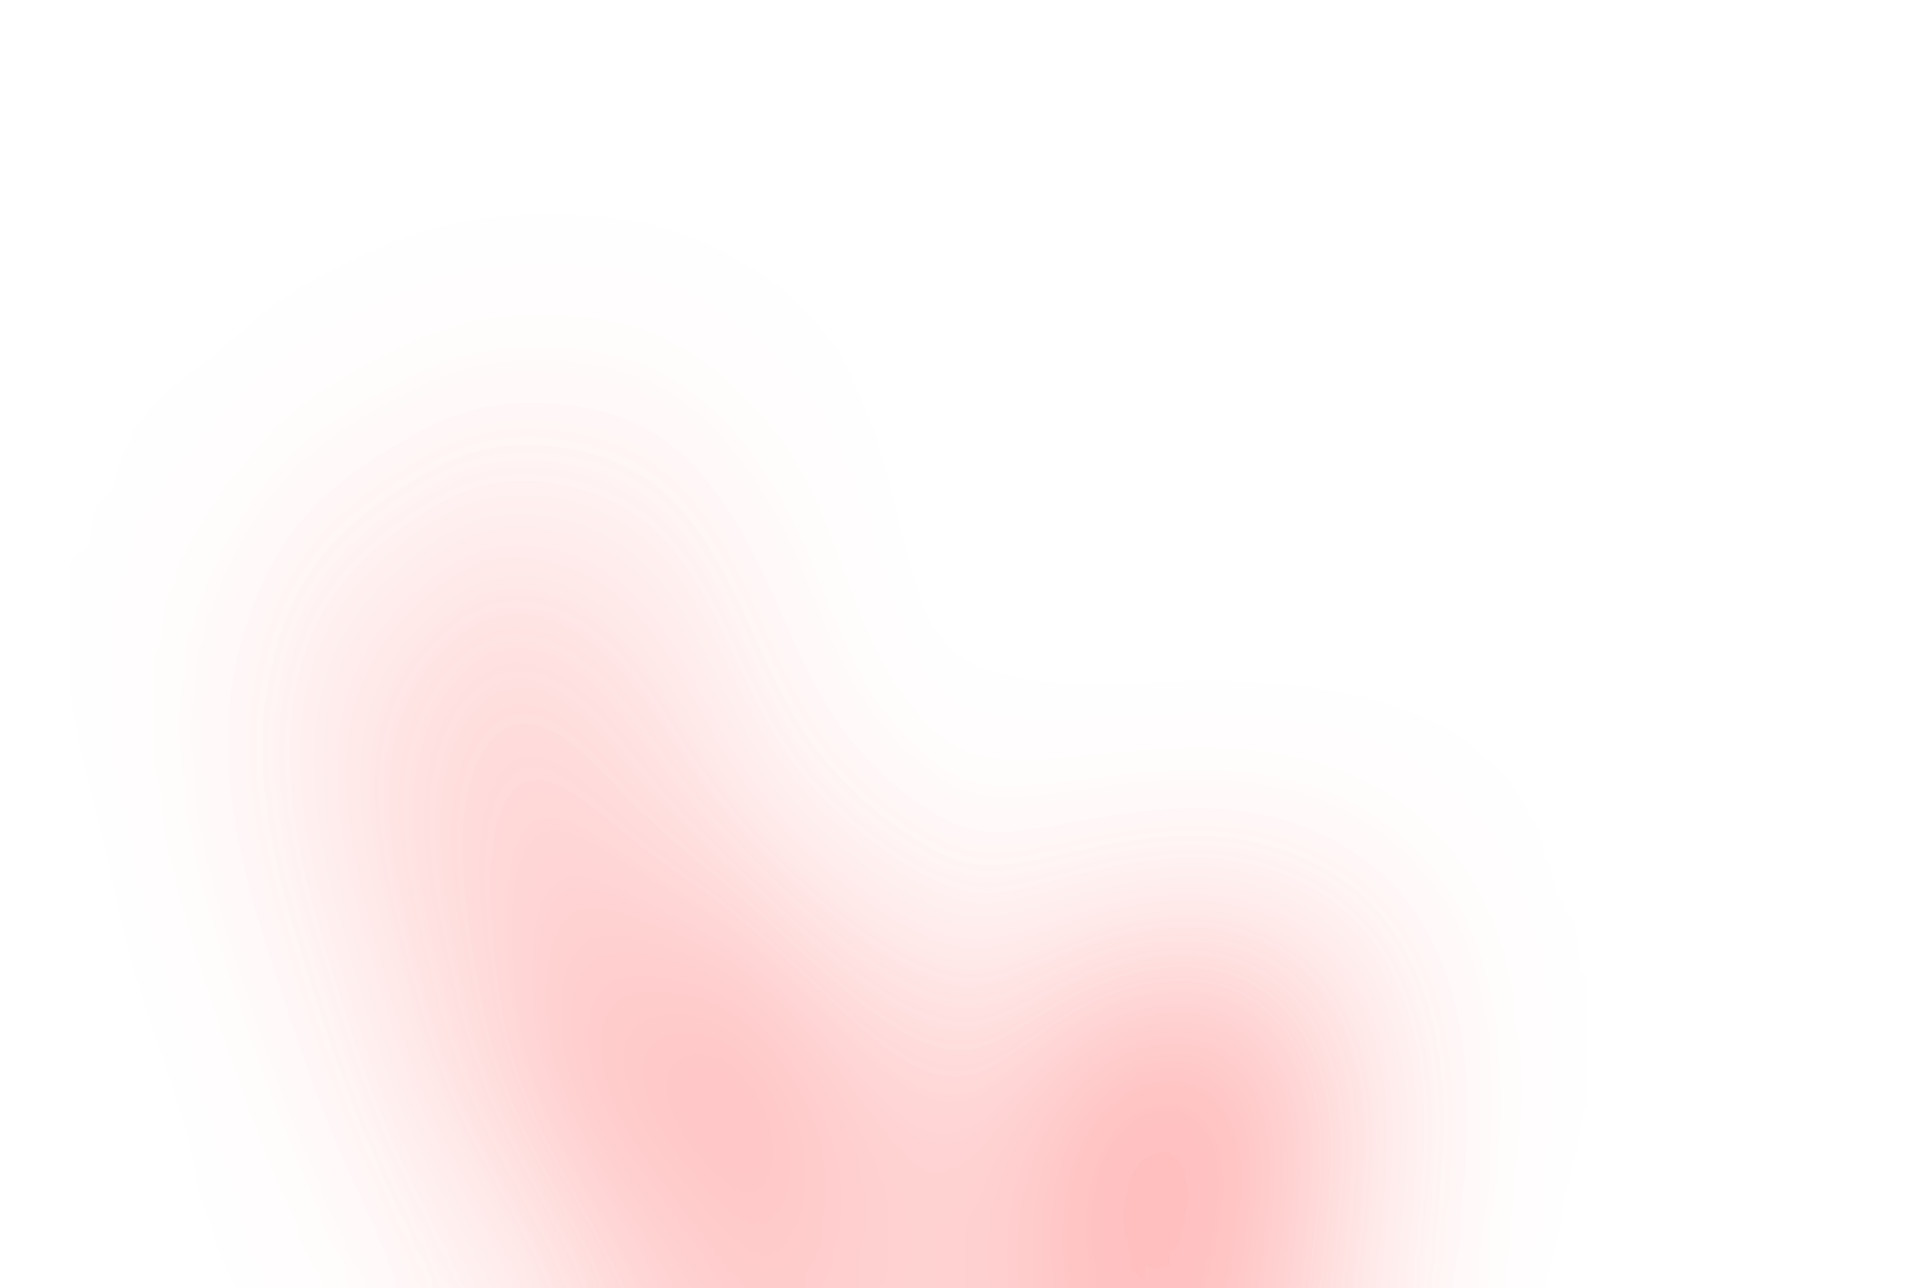

In [62]:
# now that i have the mask, lets now use that to create the color tint, using the greyscale image as alpha

halation_layer = np.stack(
    (
        np.full_like(blurred_mask, color_tint[0], dtype=np.uint8),
        np.full_like(blurred_mask, color_tint[1], dtype=np.uint8),
        np.full_like(blurred_mask, color_tint[2], dtype=np.uint8),
        blurred_mask
    ),
    axis=2
)
halation_layer
# now we can see the halation for the image
halation = Image.fromarray(halation_layer)
showSmallerVersionOfImage(halation)

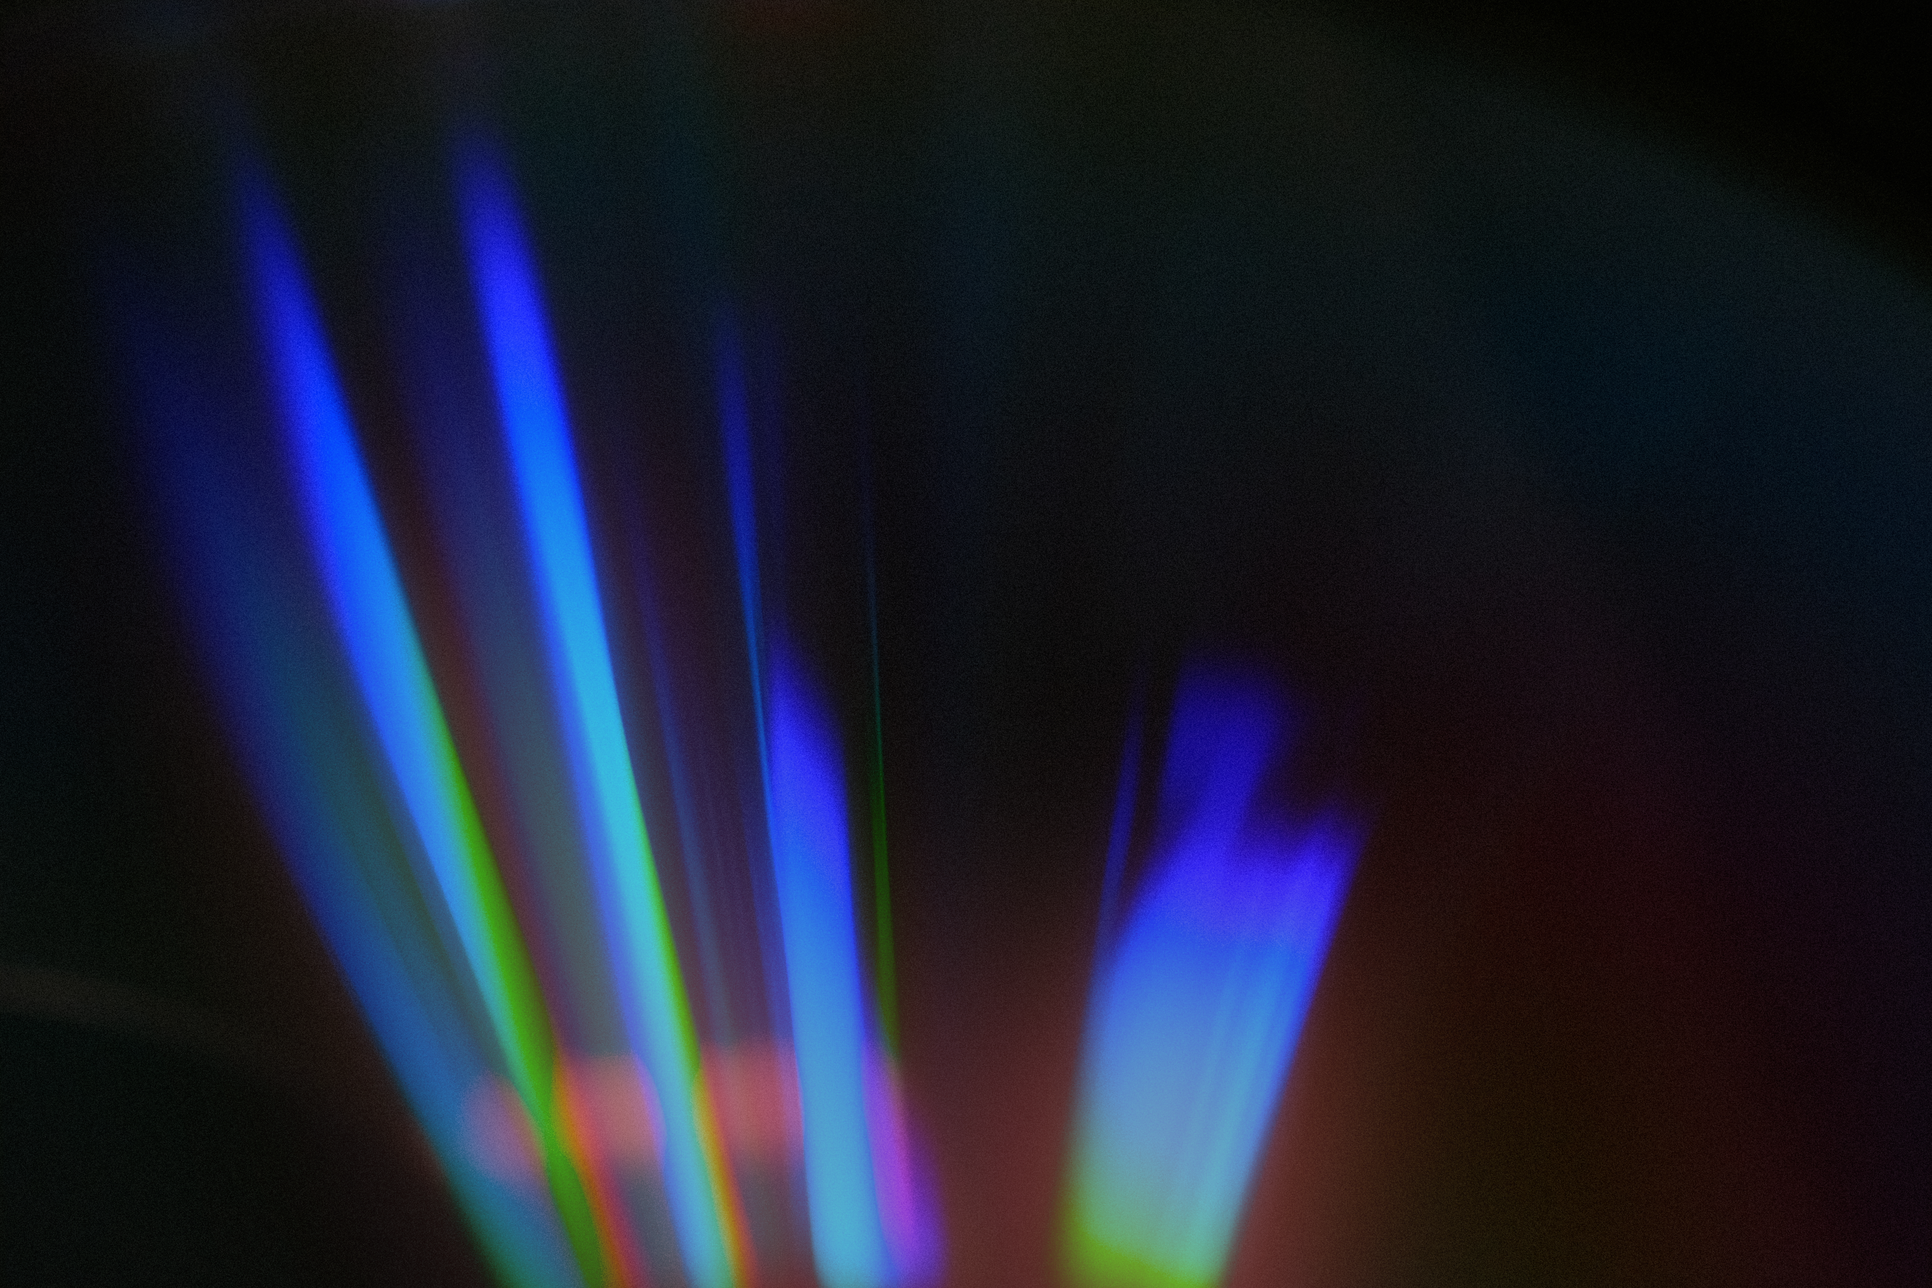

In [63]:
# now we can get halations!
image_with_halation = Image.alpha_composite(image.convert("RGBA"), halation)
showSmallerVersionOfImage(image_with_halation)